In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import timedelta
from pandas import ExcelWriter



In [6]:
pip install openpyxl


     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     ------------------------------------  245.8/250.0 kB 15.7 MB/s eta 0:00:01
     -------------------------------------- 250.0/250.0 kB 3.1 MB/s eta 0:00:00


In [8]:
data = pd.read_excel('Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Cleaning

Perform descriptive analytics on the given data
* Check for missing data
* Remove duplicate data records
* Perform descriptive analytics on the given data

In [9]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,541909.0,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
InvoiceDate,541909,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
CustomerID,406829.0,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303


In [10]:
# Dropping rows with negative quantity
data.drop(data[data['Quantity']<=0].index, inplace=True)

In [11]:
# Dropping rows with $0.00 sales
data.drop(data[data['UnitPrice'] == 0].index, inplace=True)

In [12]:
# Checking for duplicate rows in database

duplicate = data[data.duplicated()]
print(f'There are {len(duplicate)} duplacate rows in this data file')

There are 5226 duplacate rows in this data file


In [13]:
# Removing duplicate rows in database and re-checking to be sure the database is clear of duplicates.

data = data.drop_duplicates()
duplicate_check = data[data.duplicated()]
print(f'There are {len(duplicate_check)} duplacate rows in this data file')

There are 0 duplacate rows in this data file


In [14]:
# Checking for missing values

data.isna().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [15]:
Customer_id_isna = data[pd.isnull(data['CustomerID'])]
print('There are: ' + str(len(pd.unique(Customer_id_isna['InvoiceNo']))) + ' Invoices with no Customer ID')
Customer_id_isna

There are: 1430 Invoices with no Customer ID


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [16]:
# Will drop all rows with no Customer ID

data.dropna(subset=['CustomerID'], inplace=True)

In [17]:
# Checking for missing values again

data.isna().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
Country        False
dtype: bool

# Data Transformation
### Perform cohort analysis (a cohort is a group of subjects that share a defining characteristic). Observe how a cohort behaves across time and compare it to other cohorts.
* Create month cohorts and analyze active customers for each cohort
* Analyze the retention rate of customers

In [19]:
data['Month'] = data['InvoiceDate'].dt.to_period('M')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12


In [22]:
# Convert to InvoiceDate to Year-Month format
data['month_year'] = data['InvoiceDate'].dt.to_period('M')
data['month_year'].nunique()

13

In [23]:
month_cohort = data.groupby('month_year')['CustomerID'].nunique()
month_cohort

month_year
2010-12     885
2011-01     741
2011-02     758
2011-03     974
2011-04     856
2011-05    1056
2011-06     991
2011-07     949
2011-08     935
2011-09    1266
2011-10    1364
2011-11    1664
2011-12     615
Freq: M, Name: CustomerID, dtype: int64

In [24]:
data['cohort'] = data.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [25]:
data.tail(50)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,month_year,cohort
541859,581580,37500,TEA TIME TEAPOT IN GIFT BOX,1,2011-12-09 12:20:00,4.95,12748.0,United Kingdom,2011-12,2011-12,2010-12
541860,581581,23562,SET OF 6 RIBBONS PERFECTLY PRETTY,6,2011-12-09 12:20:00,2.89,17581.0,United Kingdom,2011-12,2011-12,2010-12
541861,581581,23561,SET OF 6 RIBBONS PARTY,6,2011-12-09 12:20:00,2.89,17581.0,United Kingdom,2011-12,2011-12,2010-12
541862,581581,23681,LUNCH BAG RED VINTAGE DOILY,10,2011-12-09 12:20:00,1.65,17581.0,United Kingdom,2011-12,2011-12,2010-12
541863,581582,23552,BICYCLE PUNCTURE REPAIR KIT,6,2011-12-09 12:21:00,2.08,17581.0,United Kingdom,2011-12,2011-12,2010-12
541864,581582,23498,CLASSIC BICYCLE CLIPS,12,2011-12-09 12:21:00,1.45,17581.0,United Kingdom,2011-12,2011-12,2010-12
541865,581583,20725,LUNCH BAG RED RETROSPOT,40,2011-12-09 12:23:00,1.45,13777.0,United Kingdom,2011-12,2011-12,2010-12
541866,581583,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,36,2011-12-09 12:23:00,1.85,13777.0,United Kingdom,2011-12,2011-12,2010-12
541867,581584,20832,RED FLOCK LOVE HEART PHOTO FRAME,72,2011-12-09 12:25:00,0.72,13777.0,United Kingdom,2011-12,2011-12,2010-12
541868,581584,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,48,2011-12-09 12:25:00,1.85,13777.0,United Kingdom,2011-12,2011-12,2010-12


Text(0.5, 1.0, 'No. of active customers in each month')

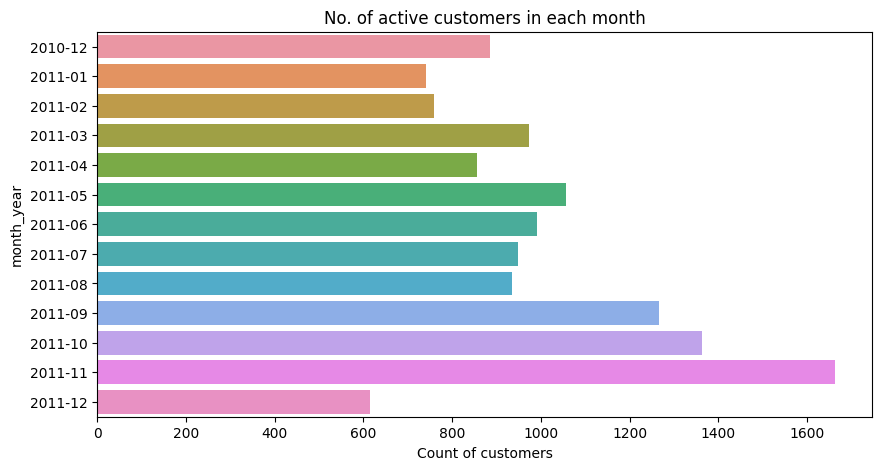

In [26]:
plt.figure(figsize=(10,5))
sns.barplot(y = month_cohort.index, x = month_cohort.values);
plt.xlabel("Count of customers")
plt.title("No. of active customers in each month")

In [27]:
from operator import attrgetter
data_cohort = data.groupby(['cohort', 'Month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
data_cohort['period_number'] = (data_cohort.Month - data_cohort.cohort).apply(attrgetter('n'))

In [28]:
data_cohort.head()

,cohort,Month,n_customers,period_number
0,2010-12,2010-12,885,0
1,2010-12,2011-01,324,1
2,2010-12,2011-02,286,2
3,2010-12,2011-03,340,3
4,2010-12,2011-04,321,4


In [29]:
cohort_pivot = data_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [30]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

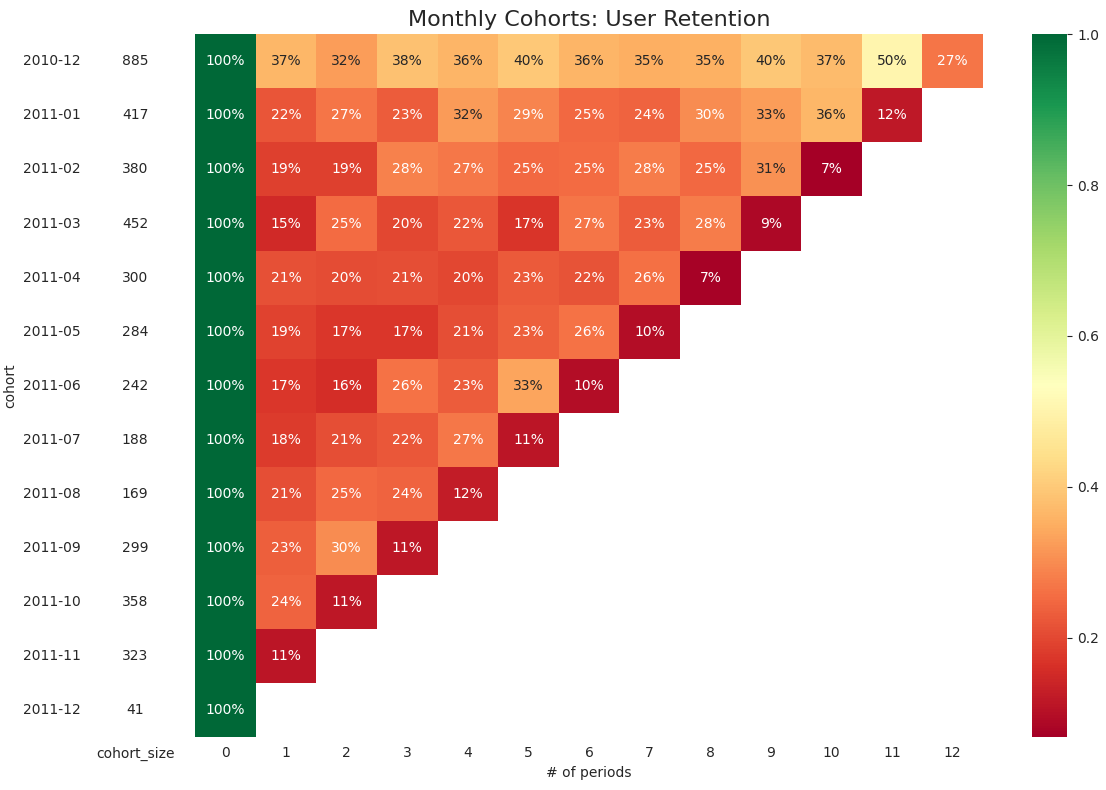

In [31]:
import seaborn as sns
import matplotlib.colors as mcolors

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

* There is a significant drop off in retention after the first month.
* Each subsequent month is about 20% to 30% retention
* The first cohort, 2010-12, seems to be the most consistent with the highest retention percents
* December is the least consistent month with much lower retention percent than any other month.

### Data Modeling
#### Build a RFM (Recency Frequency Monetary) model. Recency means the number of days since a customer made the last purchase. Frequency is the number of purchases in a given period.  It could be 3 months, 6 months, or 1 year. Monetary is the total amount of money a customer spent in that givn period. Therefore, big spenders will be differentiated among other customers such as MVP (Minimum Viable Product) or VIP. 

#### Calculate RFM Metrics

#### Build RFM Segments. Give Recency, Frequency, and Monetary scores indivudually by dividing them into quartiles. 
* Combine three ratings to gt a RFM segment (as strings)
* Get the RFM Score by adding up the three ratings. 
* Analyze the RFM segments by summarizing thm and comment on the findings
 
 #### Note:
  * Rate "Recency" for customer who has been active more recently hgher than less recent customer, because each comapany wants its customers to be recent. 
  * Rate "Frequency" and "Monetary" higher, because the company wants the customer to visit more often and spend more money. 

In [32]:
from datetime import datetime
recency_now_date = data['InvoiceDate'].max()
recency = data.groupby('CustomerID', as_index=False)['InvoiceDate'].max()
recency.columns = ['CustomerID','max_date']
recency['Recency'] = recency['max_date'].apply(lambda row: (recency_now_date - row).days)
recency.drop(['max_date'], axis=1, inplace=True)
recency.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [33]:
frequency = data.groupby('CustomerID', as_index=False)['InvoiceNo'].nunique()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [34]:
data['OrderTotal'] = data['Quantity'] * data['UnitPrice']
monetary = data.groupby('CustomerID', as_index=False)['OrderTotal'].sum()
monetary.columns = ['CustomerID', 'Monetary']
monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [35]:
rf_data = pd.merge(recency, frequency, how='right')
rfm_data = pd.merge(rf_data, monetary, how='right')
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


In [36]:
rfm_data["RecencyScore"] = pd.cut(rfm_data["Recency"], 
                                       bins=[-1, 
                                         np.percentile(rfm_data["Recency"], 25), 
                                             np.percentile(rfm_data["Recency"], 50), 
                                             np.percentile(rfm_data["Recency"], 75), 
                                             rfm_data["Recency"].max()], 
                                       labels=[4, 3, 2, 1]).astype("int")

rfm_data["FrequencyScore"] = pd.cut(rfm_data["Frequency"], 
                                       bins=[-1, 
                                         np.percentile(rfm_data["Frequency"], 25), 
                                             np.percentile(rfm_data["Frequency"], 50), 
                                             np.percentile(rfm_data["Frequency"], 75), 
                                             rfm_data["Frequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")

rfm_data["MonetaryScore"] = pd.cut(rfm_data["Monetary"], 
                                       bins=[-1, 
                                         np.percentile(rfm_data["Monetary"], 25), 
                                             np.percentile(rfm_data["Monetary"], 50), 
                                             np.percentile(rfm_data["Monetary"], 75), 
                                             rfm_data["Monetary"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")

rfm_data['RFM_Score'] = rfm_data['RecencyScore'] + rfm_data['FrequencyScore'] + rfm_data['MonetaryScore']

In [37]:
# Looking at the RFM data to see how it was segmented. 
rfm_segmentation = pd.DataFrame()
rfm_segmentation['RecencyMinValue'] = rfm_data.groupby('RecencyScore')['Recency'].min()
rfm_segmentation['RecencyMaxValue'] = rfm_data.groupby('RecencyScore')['Recency'].max()
rfm_segmentation['FrequencyMinValue'] = rfm_data.groupby('FrequencyScore')['Frequency'].min()
rfm_segmentation['FrequencyMaxValue'] = rfm_data.groupby('FrequencyScore')['Frequency'].max()
rfm_segmentation['MonetaryMinValue'] = rfm_data.groupby('MonetaryScore')['Monetary'].min()
rfm_segmentation['MonetaryMaxValue'] = rfm_data.groupby('MonetaryScore')['Monetary'].max()
rfm_segmentation

,RecencyMinValue,RecencyMaxValue,FrequencyMinValue,FrequencyMaxValue,MonetaryMinValue,MonetaryMaxValue
RecencyScore,,,,,,
1,142,373,1,1,3.75,306.46
2,51,141,2,2,306.55,668.56
3,18,50,3,5,668.58,1659.75
4,0,17,6,209,1660.88,280206.02


Looking at the RFM Segments we can make the following observations:

* 25% of customers have been active in the last 17 days
* More than 25% of all customers have not been active in the last 4 and a half months
* More than 75% of customers have placed no more than 5 orders total
* Less than 25% of customers are responsible for the vast majority of overall sales at over $280k

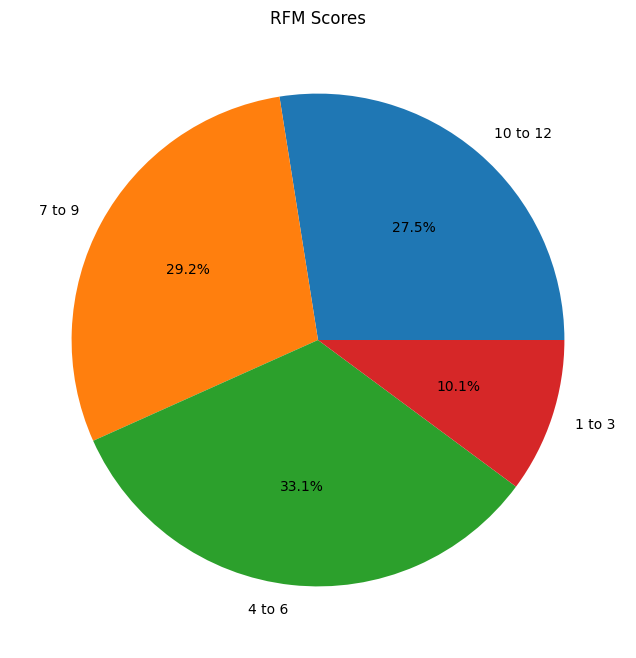

In [38]:
top = len(rfm_data[rfm_data['RFM_Score'] >= 10])
mid_top = len(rfm_data[rfm_data['RFM_Score'].isin(range(7,10))])
mid_bottom = len(rfm_data[rfm_data['RFM_Score'].isin(range(4,7))])
bottom = len(rfm_data[rfm_data['RFM_Score'] <= 3])

pie_data = ([top, mid_top, mid_bottom, bottom])
labels = ['10 to 12', '7 to 9', '4 to 6', '1 to 3']
plt.figure(figsize=(8,8))
plt.title('RFM Scores')
plt.pie(pie_data, labels=labels, autopct='%1.1f%%');

Most of the RFM Scores are somewhat equally distributed among all customers with the exception of customers with RFM Scores of 1 to 3 which is only 10% of total customers.

### Data Modeling
#### Create clusters using k-means clustering algorithm. 
* Prepare the data for the algorithm.  If the data is asymmetrically distributed, manage the skewness with appropriate transformation. Standardiz the data. 
* Decide the optimum number of clusters to be formed. 
* Analyze these clusters and comment on the results. 

In [39]:
from scipy import stats

# Function to check for skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.histplot(df_skew[column], kde=True, stat='density', linewidth=0)
    print("{}'s: Skew {}, : {}".format(column, skew, skewtest))
    return

In [40]:
rfm_segments = rfm_data[['CustomerID', 'Recency', 'Frequency', 'Monetary']]
rfm_segments.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


Recency's: Skew 1.2456166142880103, : SkewtestResult(statistic=26.606793376917242, pvalue=5.664292789640091e-156)
Frequency's: Skew 12.062857869870964, : SkewtestResult(statistic=74.62743613377035, pvalue=0.0)
Monetary's: Skew 19.332680144099353, : SkewtestResult(statistic=85.01187149828888, pvalue=0.0)


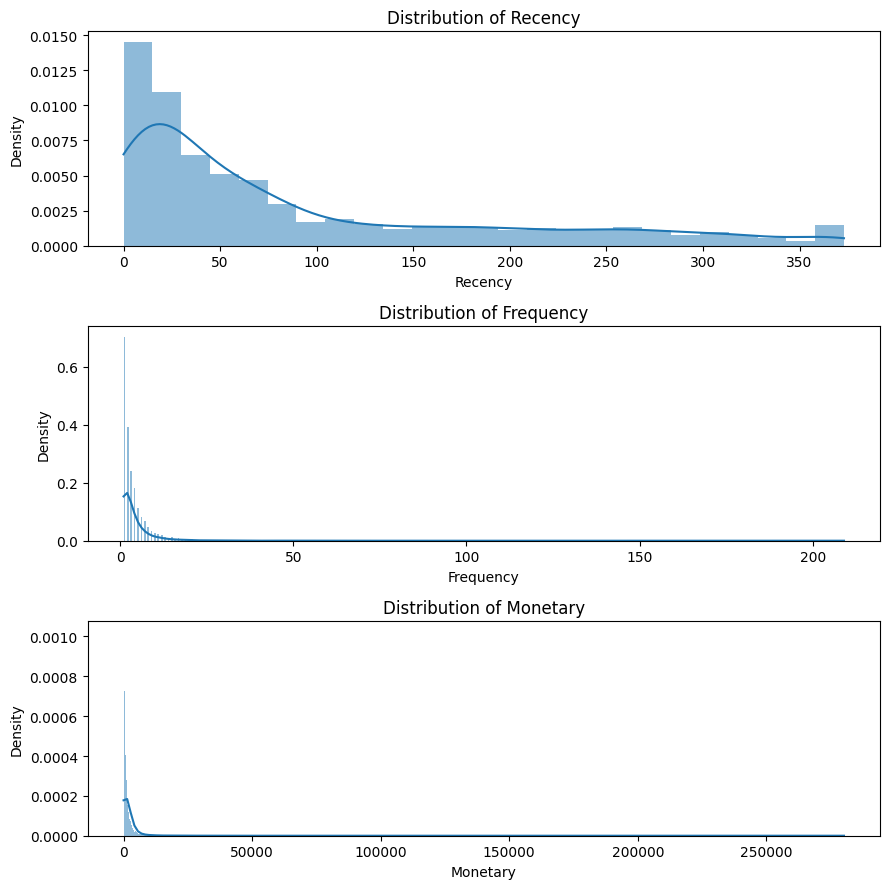

In [41]:
plt.figure(figsize=(9,9))

plt.subplot(3,1,1)
check_skew(rfm_segments, 'Recency')

plt.subplot(3,1,2)
check_skew(rfm_segments, 'Frequency')

plt.subplot(3,1,3)
check_skew(rfm_segments, 'Monetary')

plt.tight_layout()

In [42]:
rfm_data_log = rfm_segments.copy()
rfm_data_log.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


In [47]:
pip install feature-engine


     ---------------------------------------- 0.0/319.4 kB ? eta -:--:--
     -------------------------------------  317.4/319.4 kB 6.5 MB/s eta 0:00:01
     -------------------------------------- 319.4/319.4 kB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
     - -------------------------------------- 0.4/9.4 MB 8.7 MB/s eta 0:00:02
     --- ------------------------------------ 0.9/9.4 MB 9.4 MB/s eta 0:00:01
     ---- ----------------------------------- 1.1/9.4 MB 7.5 MB/s eta 0:00:02
     ------- -------------------------------- 1.8/9.4 MB 9.6 MB/s eta 0:00:01
     --------- ------------------------------ 2.2/9.4 MB 10.2 MB/s eta 0:00:01
     --------- ------------------------------ 2.2/9.4 MB 10.2 MB/s eta 0:00:01
     ---------- ----------------------------- 2.5/9.4 MB 8.0 MB/s eta 0:00:01
     --------------- ------------------------ 3.5/9.4 MB 9.4 MB/s eta 0:00:01
     --------------- ------------------------ 3.5/9.4 MB 9.4 MB/s eta 

Recency's: Skew -0.3863807061514661, : SkewtestResult(statistic=-10.055002925140908, pvalue=8.731884165686116e-24)
Frequency's: Skew 0.7220853981502767, : SkewtestResult(statistic=17.54001378255881, pvalue=7.091019464639143e-69)
Monetary's: Skew 0.16491244333780397, : SkewtestResult(statistic=4.412400335006802, pvalue=1.0223085847018888e-05)


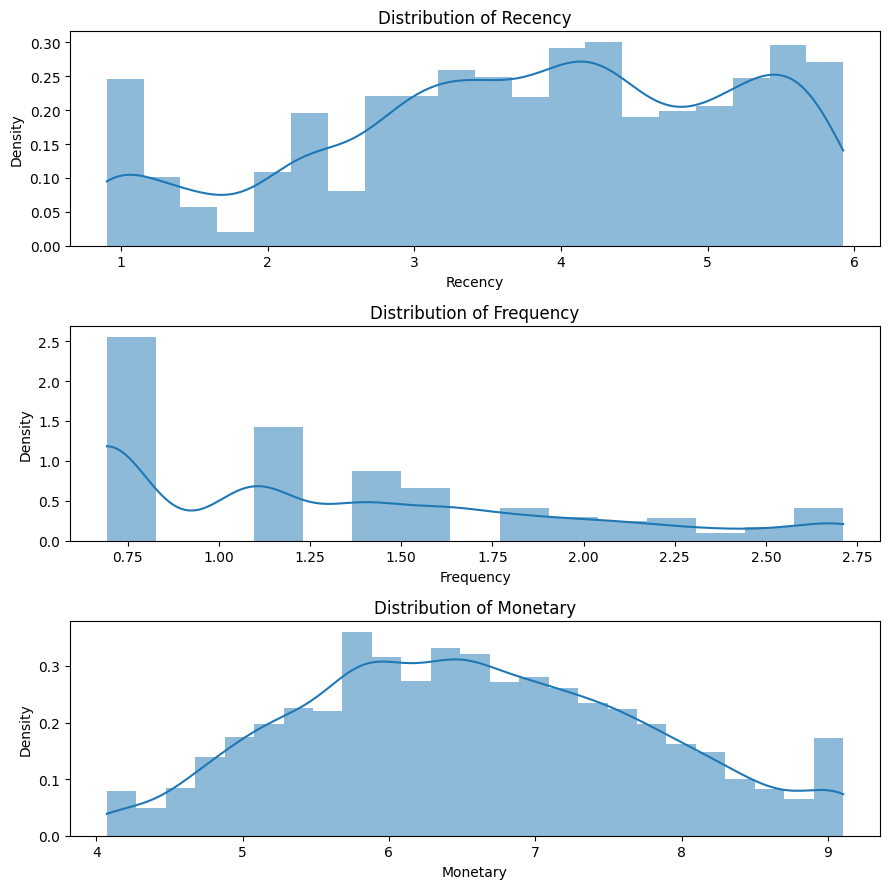

In [48]:
import feature_engine
from feature_engine.outliers import Winsorizer

rfm_data_log = np.log(rfm_data_log+1)

winsorizer = Winsorizer(tail='both', fold=2, variables=['Recency', 'Frequency', 'Monetary'])
winsorizer.fit(rfm_data_log)

rfm_data_log = winsorizer.transform(rfm_data_log)

plt.figure(figsize=(9,9))

plt.subplot(3,1,1)
check_skew(rfm_data_log, 'Recency')

plt.subplot(3,1,2)
check_skew(rfm_data_log, 'Frequency')

plt.subplot(3,1,3)
check_skew(rfm_data_log, 'Monetary')

plt.tight_layout()

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rfm_data_log)
rfm_data_scaled = scaler.transform(rfm_data_log)

In [50]:
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(rfm_data_scaled)
    kmeanModel.fit(rfm_data_scaled)
  
    distortions.append(sum(np.min(cdist(rfm_data_scaled, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / rfm_data_scaled.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(rfm_data_scaled, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / rfm_data_scaled.shape[0]
    mapping2[k] = kmeanModel.inertia_

C:\Users\91805\anaconda1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\91805\anaconda1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\91805\anaconda1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\91805\anaconda1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\91805\anaconda1\lib\site-packages\sklearn\clust

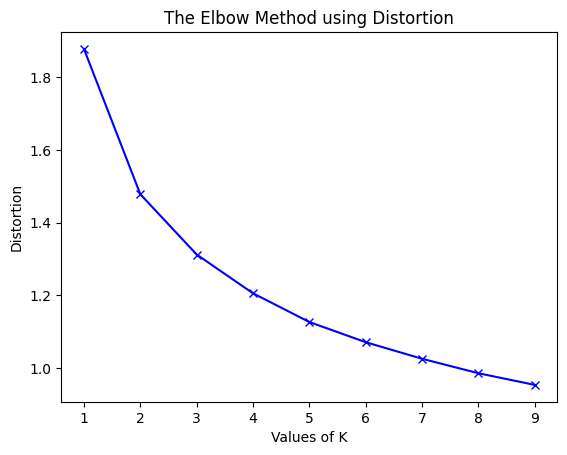

In [51]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

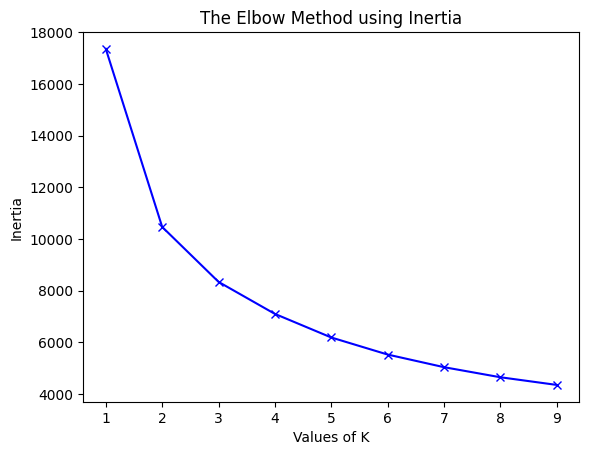

In [52]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [53]:
from sklearn.manifold import TSNE

def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    kmeans = KMeans(n_clusters = clusters_number, random_state=1)
    kmeans.fit(normalised_df_rfm)
    
    cluster_labels = kmeans.labels_
    
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    plt.title('Flattned Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:, 1], hue=cluster_labels, style=cluster_labels, palette='Set1')
    
    return df_new

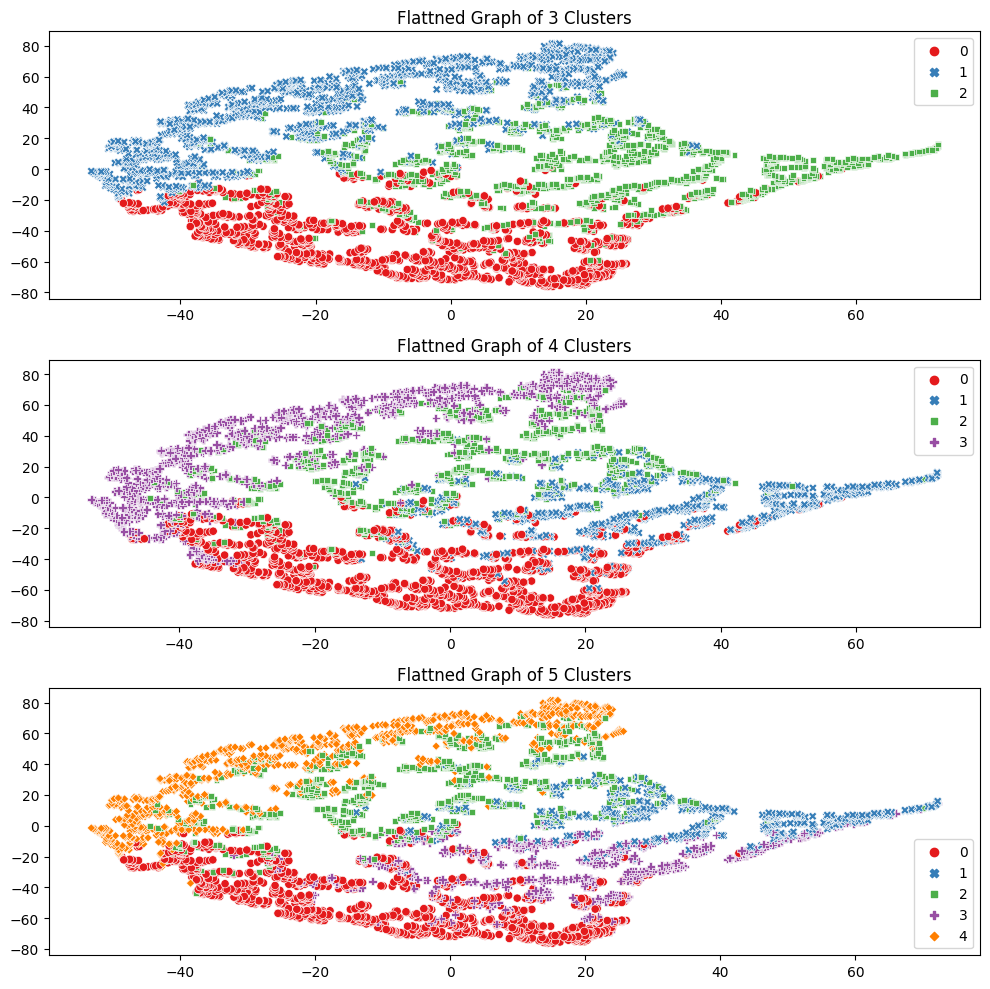

In [55]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
df_rfm_k3 = kmeans(rfm_data_scaled, 3, rfm_segments)

plt.subplot(3,1,2)
df_rfm_k4 = kmeans(rfm_data_scaled, 4, rfm_segments)

plt.subplot(3,1,3)
df_rfm_k5 = kmeans(rfm_data_scaled, 5, rfm_segments)

plt.tight_layout()

In [56]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm,
                                     index=rfm_segments.index,
                                     columns=rfm_segments.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']
    
    df_melt = pd.melt(normalised_df_rfm.reset_index(),
                     id_vars=['CustomerID', 'Cluster'],
                     value_vars=['Recency', 'Frequency', 'Monetary'],
                     var_name='Metric',
                     value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

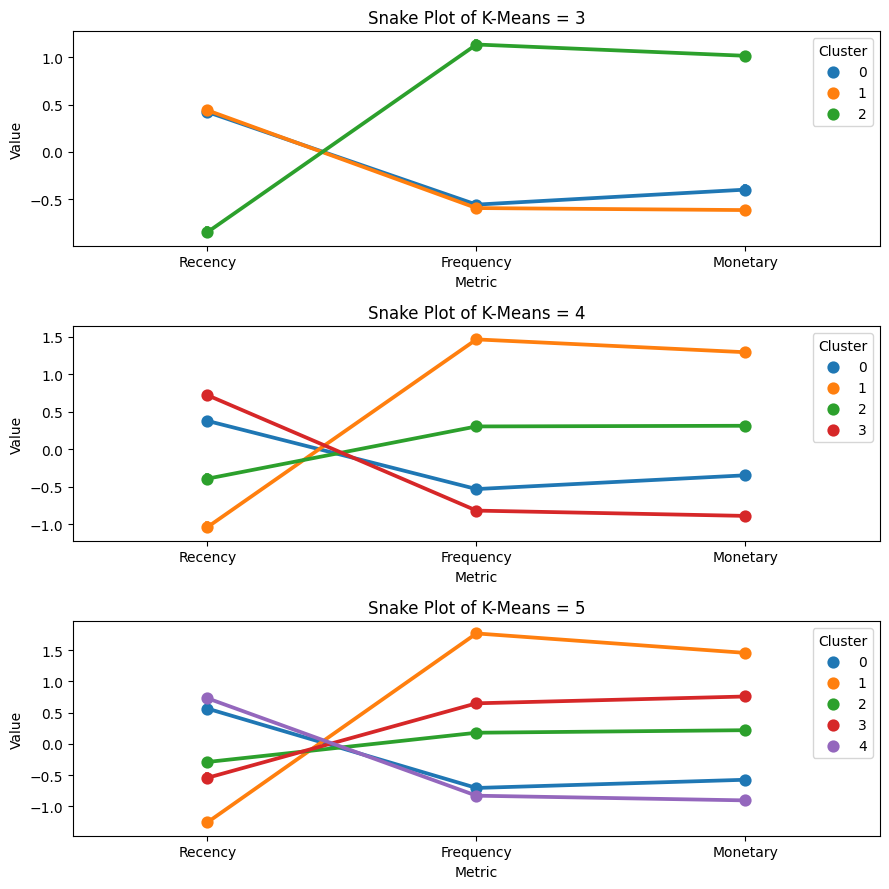

In [57]:
plt.figure(figsize=(9,9))

plt.subplot(3,1,1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(rfm_data_scaled, df_rfm_k3, rfm_segments)

plt.subplot(3,1,2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(rfm_data_scaled, df_rfm_k4, rfm_segments)

plt.subplot(3,1,3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(rfm_data_scaled, df_rfm_k5, rfm_segments)

plt.tight_layout()

In [58]:
df_rfm_k4.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']
}).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         117.0       2.0    747.0  1234
1          18.0      12.0   6967.0   888
2          42.0       4.0   1362.0  1033
3         164.0       1.0    315.0  1183

Based on the resulting clustered data and going with the 4 cluster selection as that seems to be most appropriate separation of data, we can make the following statements regarding the clusters. 
* Cluster 0. Less Recently Active - Less Frequent - Medium Monetary Value. 
* Cluster 1. Most Recently Active - Most Frequent - Highest Monetary Value
* Cluster 2. Recently Active - Frequent - Good Monetary Value
* Cluster 3. Least Recently Active - One Time Frequency - Least Monetary Value

* Cluster 1 and 3 are the current valued customers worth trying to retain, with Cluster 1 being the Most Valued Customers.
* Clusters 0 and 3 are most likely passerby customers that are possibly already lost or on the verge of being lost